<a href="https://colab.research.google.com/github/Alex-Witt/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=93.05705310120305, mobile=True), User(purchased=False, time_on_site=104.09696748435019, mobile=True), User(purchased=False, time_on_site=44.898081001711674, mobile=False), User(purchased=False, time_on_site=182.84845765071373, mobile=True), User(purchased=False, time_on_site=298.07260881686506, mobile=True), User(purchased=False, time_on_site=273.1884736868269, mobile=False), User(purchased=False, time_on_site=300.58075219988643, mobile=False), User(purchased=False, time_on_site=14.550225837279621, mobile=True), User(purchased=False, time_on_site=420.22159295160134, mobile=False), User(purchased=False, time_on_site=72.19039898109838, mobile=False)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,93.057053,True
1,False,104.096967,True
2,False,44.898081,False
3,False,182.848458,True
4,False,298.072609,True


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.257937873381667,5.406759316357766,5.607175686974564,5.9969956487325895,6.613125080368587,6.694214805212852,6.6973109646099225,6.882981672652149,7.214624307715347,7.518108692680404,...,579.0327523591628,579.7290733502037,584.5048659934799,585.134197758422,588.3992099716922,588.6210881200878,589.7149740365938,591.7777163442875,596.8146796444377,598.1896413302231
purchased,,,,,,,,,,,,,,,,,,,,,
False,0,1,0,0,1,1,1,1,1,0,...,0,1,0,1,1,1,1,0,1,0
True,1,0,1,1,0,0,0,0,0,1,...,1,0,1,0,0,0,0,1,0,1


In [6]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.665, 123.844]","(123.844, 242.431]","(242.431, 361.017]","(361.017, 479.603]","(479.603, 598.19]"
purchased,,,,,
False,231,210,109,27,25
True,113,160,82,18,25


In [7]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.665, 123.844]","(123.844, 242.431]","(242.431, 361.017]","(361.017, 479.603]","(479.603, 598.19]"
purchased,,,,,
False,0.671512,0.567568,0.570681,0.6,0.5
True,0.328488,0.432432,0.429319,0.4,0.5


In [8]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.676,0.577333
True,0.324,0.422667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

# Data Import and Cursory Observation


I want to run a build of few scatterplots so I can get an idea of the shape of the data. Afterwards I am going to build some functions to test that shape in more minute detail in order to find correlation and spurious connections. 

In [0]:
import matplotlib.pyplot as plt
import pandas as np
import numpy as np

In [11]:
df = pd.read_csv('https://raw.githubusercontent.com/Alex-Witt/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')

print(df.shape)
print(df.isnull().sum())
df.head()

(1200, 4)
Unnamed: 0       0
age              0
weight           0
exercise_time    0
dtype: int64


,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


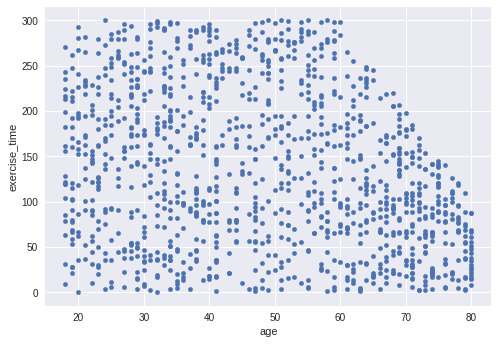

In [12]:
df.plot.scatter(x = 'age' , y = 'exercise_time');

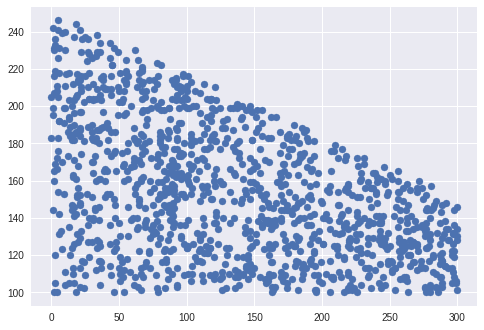

In [13]:
plt.scatter(df.exercise_time , df.weight )

Based on the scatterplot above, (excercise time vs weight) it seems there is a notable correlation between the two. Similarly, there seems to be a smaller correlation between excercise time and age. 

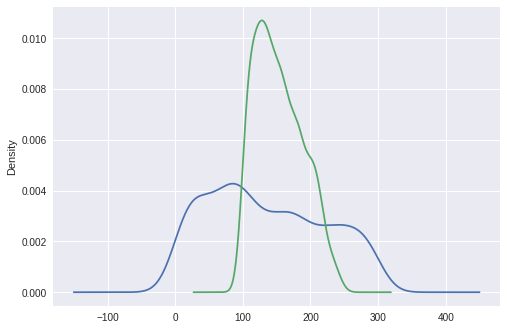

In [35]:
#I want to get a look at the density of the participannts. 

df.exercise_time.plot.density();
df.weight.plot.density();

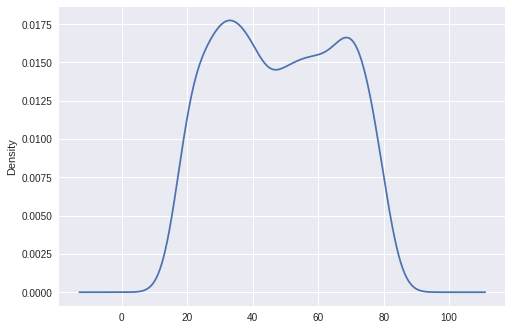

In [15]:
df.age.plot.density();

From what I can tell, the samples are pretty spread out for Age and Excercise time. Excercise time has a slight slope, whereas age has a pretty even plateau (if cratering a little). Weight is very concentrated and falls off precipitously at higher values. That seems to correlate with the data presented in the weight vs. excercise scatterplot. 

# A Deeper Look

In [0]:
#Let's start with 8 bins on the x and y axis
#I'm going to keep my functions testing the data in more minute detail here. 

n_bins =  8 
weight = pd.cut(df.weight,n_bins)
exercise = pd.cut(df.exercise_time,n_bins)
age = pd.cut(df.age,n_bins)

def cross(dep , ind):
  res = pd.crosstab(dep,ind)
  return res

def crossum(dep , ind):
  resum = pd.crosstab(dep.count(),ind)
  return resum

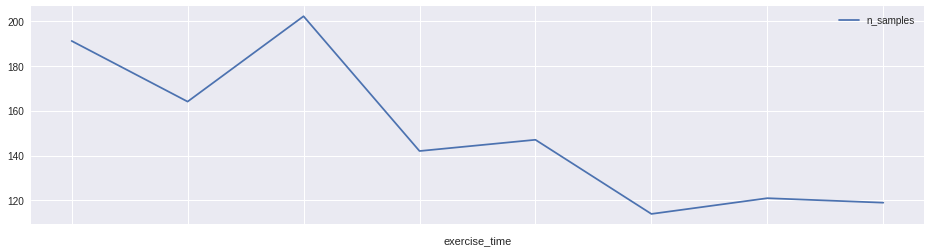

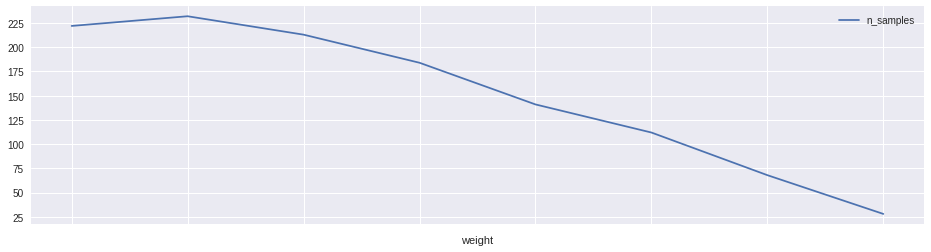

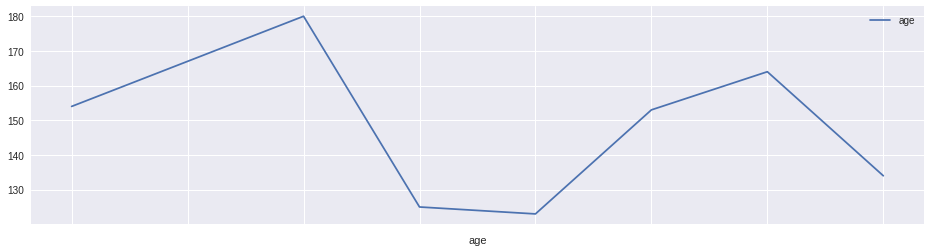

In [39]:
n_age = pd.pivot_table(crossum(exercise, age), columns = 'age')
n_ex = pd.pivot_table(crossum(age, exercise) , columns = 'exercise_time')
n_w = pd. pivot_table(crossum(age , weight) , columns = 'weight')

n_w.columns = ['n_samples']
n_ex.columns = ['n_samples']
n_w.columns = ['n_samples']



n_ex.plot.line(figsize = (16,4))
n_w.plot.line(figsize = (16,4))
n_age.plot.line(figsize = (16,4))



*   List Age looks like it stays about the same. You have similary sample sizes across the age spectrum. Longer periods of excercise are associated with less people. 
*   The sample of people excercising in the top 88th percentile are roughly have the size of the sample in the bottom 12th percentile. 
 item
*   Weight is where the largest disparity of sample size occurs. The sample of those in the 12th percentile for highest weight is almost 1/10th the size of their opposites in the bottom end of weight. 




exercise_time,"(-0.3, 37.5]","(37.5, 75.0]","(75.0, 112.5]","(112.5, 150.0]","(150.0, 187.5]","(187.5, 225.0]","(225.0, 262.5]","(262.5, 300.0]"
weight,,,,,,,,
"(99.854, 118.25]",22,22,23,26,29,31,29,40
"(118.25, 136.5]",20,18,28,23,26,34,34,49
"(136.5, 154.75]",24,20,32,18,39,23,33,24
"(154.75, 173.0]",20,25,42,24,24,18,25,6
"(173.0, 191.25]",28,25,32,24,24,8,0,0
"(191.25, 209.5]",30,24,28,25,5,0,0,0
"(209.5, 227.75]",23,26,17,2,0,0,0,0
"(227.75, 246.0]",24,4,0,0,0,0,0,0


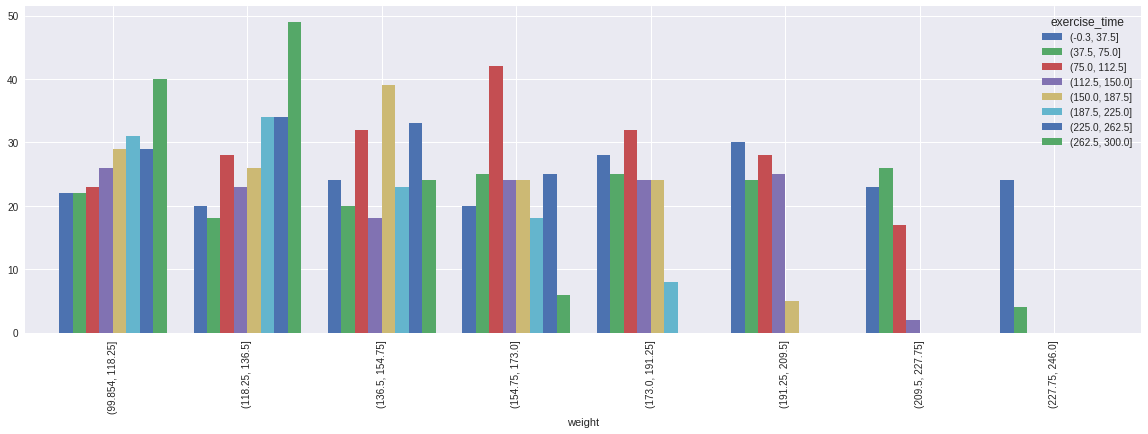

In [43]:
#Lets start with the most obvious inference, that length of excercise is associated with weight. 

cross(weight,exercise).plot.bar(figsize = (20,6),width = .8)
cross(weight,exercise)

weight,"(99.854, 118.25]","(118.25, 136.5]","(136.5, 154.75]","(154.75, 173.0]","(173.0, 191.25]","(191.25, 209.5]","(209.5, 227.75]","(227.75, 246.0]"
exercise_time,,,,,,,,
"(-0.3, 37.5]",22,20,24,20,28,30,23,24
"(37.5, 75.0]",22,18,20,25,25,24,26,4
"(75.0, 112.5]",23,28,32,42,32,28,17,0
"(112.5, 150.0]",26,23,18,24,24,25,2,0
"(150.0, 187.5]",29,26,39,24,24,5,0,0
"(187.5, 225.0]",31,34,23,18,8,0,0,0
"(225.0, 262.5]",29,34,33,25,0,0,0,0
"(262.5, 300.0]",40,49,24,6,0,0,0,0


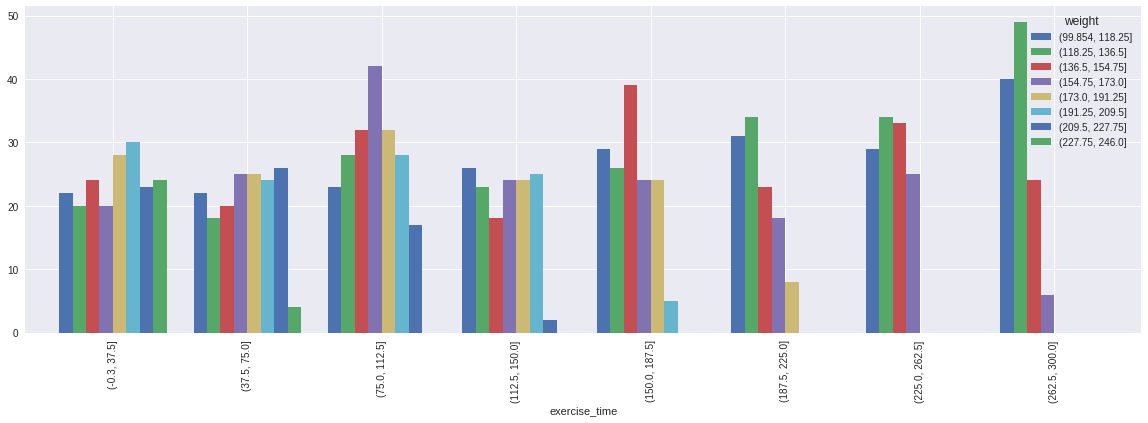

In [33]:
cross(exercise,weight).plot.bar(figsize = (20,6),width = .8)
cross(exercise,weight)

age,"(17.938, 25.75]","(25.75, 33.5]","(33.5, 41.25]","(41.25, 49.0]","(49.0, 56.75]","(56.75, 64.5]","(64.5, 72.25]","(72.25, 80.0]"
weight,,,,,,,,
"(99.854, 118.25]",31,40,44,20,24,24,21,18
"(118.25, 136.5]",26,28,40,31,29,31,29,18
"(136.5, 154.75]",30,34,31,23,22,27,27,19
"(154.75, 173.0]",30,29,17,22,17,19,29,21
"(173.0, 191.25]",16,14,21,11,15,22,19,23
"(191.25, 209.5]",14,8,20,8,8,18,20,16
"(209.5, 227.75]",3,12,5,7,7,10,10,14
"(227.75, 246.0]",4,2,2,3,1,2,9,5


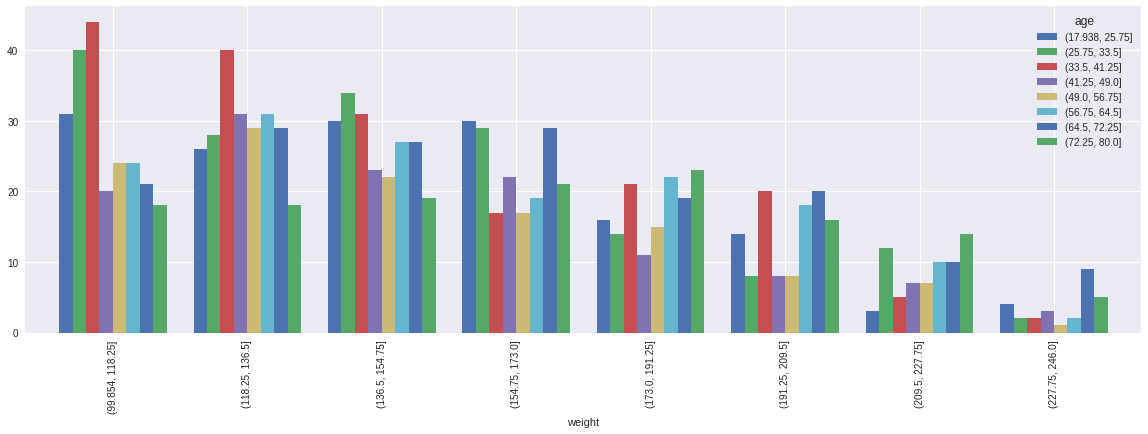

In [20]:
#The clear global trend continues. Let's see if we can catch any other global trends. 

cross(weight, age).plot.bar(figsize = (20,6),width = .8)
cross(weight,age)

weight,"(99.854, 118.25]","(118.25, 136.5]","(136.5, 154.75]","(154.75, 173.0]","(173.0, 191.25]","(191.25, 209.5]","(209.5, 227.75]","(227.75, 246.0]"
age,,,,,,,,
"(17.938, 25.75]",31,26,30,30,16,14,3,4
"(25.75, 33.5]",40,28,34,29,14,8,12,2
"(33.5, 41.25]",44,40,31,17,21,20,5,2
"(41.25, 49.0]",20,31,23,22,11,8,7,3
"(49.0, 56.75]",24,29,22,17,15,8,7,1
"(56.75, 64.5]",24,31,27,19,22,18,10,2
"(64.5, 72.25]",21,29,27,29,19,20,10,9
"(72.25, 80.0]",18,18,19,21,23,16,14,5


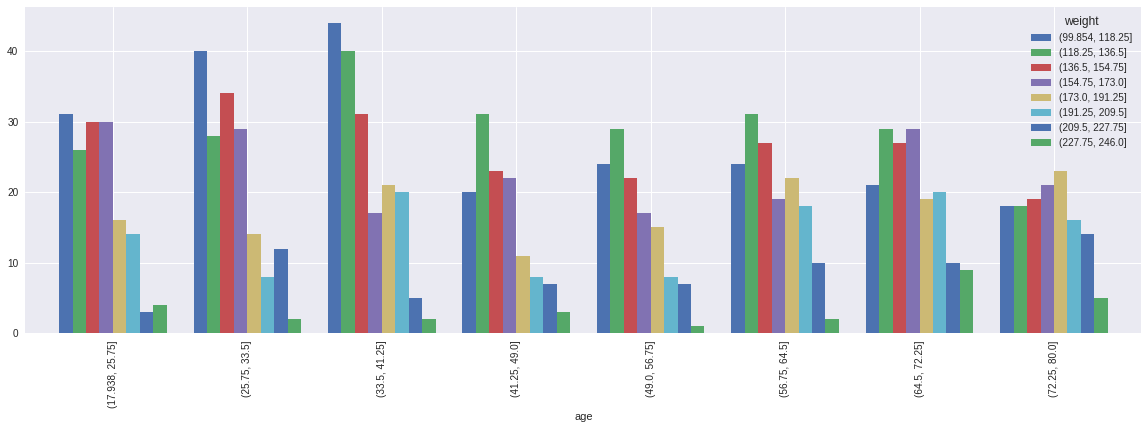

In [21]:
#Well, that makes send. You have a nice spread of people excercising across each age group, with smaller sample of older individuals. 

cross(age,weight).plot.bar(figsize = (20,6),width = .8)
cross(age,weight)

age,"(17.938, 25.75]","(25.75, 33.5]","(33.5, 41.25]","(41.25, 49.0]","(49.0, 56.75]","(56.75, 64.5]","(64.5, 72.25]","(72.25, 80.0]"
exercise_time,,,,,,,,
"(-0.3, 37.5]",18,19,27,12,12,27,35,41
"(37.5, 75.0]",16,25,17,14,13,17,27,35
"(75.0, 112.5]",20,13,35,18,13,25,41,37
"(112.5, 150.0]",22,18,14,10,17,18,23,20
"(150.0, 187.5]",24,22,21,16,15,21,27,1
"(187.5, 225.0]",23,20,23,11,11,17,9,0
"(225.0, 262.5]",19,28,19,23,16,14,2,0
"(262.5, 300.0]",12,22,24,21,26,14,0,0


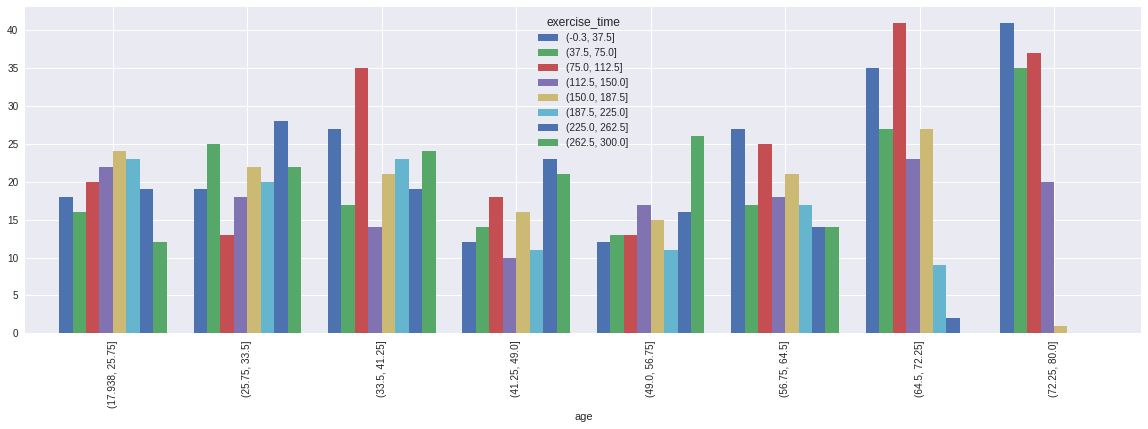

In [22]:
cross(age, exercise).plot.bar(figsize = (20,6),width = .8)
cross(exercise, age)



*   **Variable Types:** Person = Index (Discrete in theory but functionally Continuous), Exercise, Age and Weight are all Discrete but can be treated as continuous. 
*   **Relationships Between the Variables:** The most noticeable association was between **time spent exercising**  and **weight**. Those spent a large amount of time exercising were well below the average for weight, whereas those who were obese spent a short amount of time exercising. Similarly, younger people were more likely to exercise for long periods, decreasing the rates of obesity among those under 40. The rates of obesity (>250lb.) were much higher for those above 40. 
*   **Real Relationships vs. Spurious:** The spurious relationships come from how an observation is phrased. For example, one could state that; "Those who exercised less were more likely to obese". This is correlative, but potentially spurious as the sample size for those >250lb. was significantly smaller than other samples. A more accurate observation would be to say the "Those who weigh more are highly unlikely to exercise for longer than 30 minutes per (arbitrary unit).



### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)